# Clone du projet " Grad-CAM: How to visualize class activation maps to bring Interpretability to Deep Learning"
### Nouvelles données utilisées : image de poisson
### Réalisé par : Moqim Ghizlan et Thibaut JUILLARD

Les modèles de Deep Learning sont souvent considérés comme des "boîtes noires" car nous ne savons pas exactement pourquoi une sortie donnée est liée à une entrée spécifique.

Comme expliqué dans l'article original, **"Grad-CAM utilise le gradient de n'importe quel concept cible qui s'écoule dans la dernière couche convolutionnelle pour produire une carte de localisation approximative mettant en évidence les régions importantes de l'image pour prédire ce concept."**

Pour le dire de manière plus simple, la méthode Grad-CAM **permet de savoir quelle partie de l'image le modèle a regardée pour prendre sa décision**, ou plus précisément, **quelle partie de l'image a le plus contribué à sa prédiction**.

Le concept est simple et direct, car nous allons :

1.   Trouver et isoler la dernière couche convolutionnelle d'un réseau de neurones pré-entraîné
2.   Calculer le gradient qui s'écoule vers cette couche et colorier sa valeur sous forme de carte thermique

## Setup

In [ ]:
# Usual Imports for Deep Learning
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


Here we are going to use the model Xception (doc here: https://keras.io/api/applications/xception/). You can change it to use any other model.

We use model.summary() to see the names of all layers in the model and find the name of the last convolutional layer.

In [ ]:
# Prepare the model. model_builder() is used to load Xception with Keras
# You can check the documentation of those functions on https://www.tensorflow.org
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions


# Create the model, by using pretrained weights on ImageNet
model = model_builder(weights="imagenet")
print(model.summary())

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


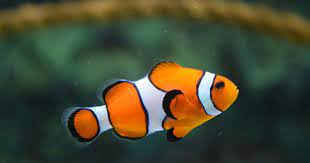

In [ ]:
# Isolate the last convolutional layer
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
#img_path = keras.utils.get_file(
#    "rabbit.jpg", "https://i.imgur.com/vH1MxgA.png"
#)
img_path = '/content/poisson.jpg'

# Visualize the image
display(Image(img_path))

## The Grad-CAM algorithm

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3). We do this because this dimension is needed for most built-in functions
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=1):
    # The variable "prediction_rank" is used to apply gradcam on the top class
    # You can modify it to prediction_rank=n for a heatmap on the nth top class

    # First, we create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # GradientTape() is a built-in Tensorflow tool to record operations for automatic differentiation.
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # We compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        # We pass the activations of the last conv in our classifier_model to obtain the predictions of the model
        preds = classifier_model(last_conv_layer_output)
        # This prediction has a shape=(1, 1000) because there is 1000 classes in ImageNet.
        # We find the index of the top prediction and we call it pred_index, because it's the index of the prediction
        pred_index = tf.argsort(preds)[0][-prediction_rank]
        # We only keep the value of the prediction at the position of the pred_index
        top_class_channel = preds[:, pred_index]


    # This is the gradient of the top predicted class with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with respect to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of activation for the top class
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Let's use it

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top 1 Prediction: [('n02607072', 'anemone_fish', 0.50916153)]
Top 3 Predictions: [('n02607072', 'anemone_fish', 0.50916153), ('n02606052', 'rock_beauty', 0.047144923), ('n01914609', 'sea_anemone', 0.02410575)]


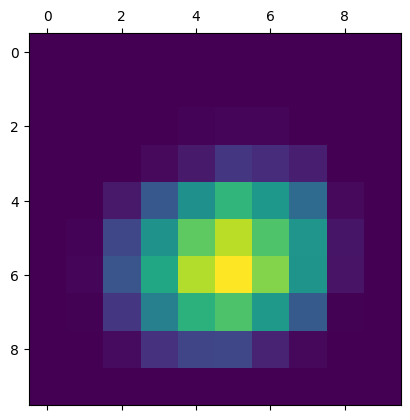

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is (Angora stands for Angora Rabbit in ImageNet labels)
# According to https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/decode_predictions
# decode_predictions() returns a list of lists of top class prediction tuples (class_name, class_description, score)
# class_name is the internal name of the class, class_description the name in natural language and score is the probability of this prediction.
# top=1 is used to have the top class and [0] to have the first element of the list.
preds = model.predict(img_array)
print("Top 1 Prediction:", decode_predictions(preds, top=1)[0])

# In order to check the 2nd and 3rd predicted class, we also print the predictions with top=3
print("Top 3 Predictions:", decode_predictions(preds, top=3)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap. This heatmap is normalized for visualisation purpose, as explained in make_gradcam_heatmap()
# Thanks to that, we can know what part of the image was the most important to predict the top class
plt.matshow(heatmap)
plt.show()

## Create a superimposed visualization

Finally, we are going to superimpose this heatmap to the input image in order to easily visualize it

<ipython-input-8-fce892d7bd65>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


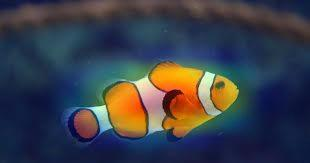

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255 (because earlier, for visualization purpose, we normalized the heatmap between 0 & 1)
# We rescale it on this range to have it in RGB, so that we can superimpose it on the rabbit picture.
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img #0.4 good value
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "poisson_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

# Rapport et Analyse Finale

## Objectif du Projet


Comme expliqué en introduction, le but est d'utiliser la méthode Grad-CAM qui permet de savoir quelle partie de l'image le modèle a regardée pour prendre sa décision, ou plus précisément, quelle partie de l'image a le plus contribué à sa prédiction.

## Analyse des Résultats

Les résultats obtenus à partir de l’implémentation de Grad‐CAM montrent que la méthode permet de générer des heatmaps clairement superposées à l’image de base. Ici, la heatmap appliquée sur l’image d’un poisson met en exergue précisément la zone correspondant au poisson. Cette visualisation démontre que le modèle de deep learning s’est concentré sur la région pertinente pour effectuer sa prédiction. Ainsi, l’analyse qualitative de ces résultats indique que Grad‐CAM est efficace pour révéler quelles parties de l’image influencent le plus la décision du modèle, ce qui contribue à lever le voile sur le caractère "boîte noire" des réseaux de neurones.

## Points Positifs et Limites

**Points Positifs :**
• Interprétabilité accrue : Grad‐CAM offre une visualisation intuitive en générant des heatmaps qui identifient les zones importantes (ici, le poisson) pour la prédiction.
• Intégration simple : La méthode peut être ajoutée facilement à un réseau de neurones pré-entraîné sans modification de l’architecture, ce qui en fait un outil pratique pour divers modèles CNN.
• Validation visuelle : La superposition de la heatmap sur l’image d’origine permet aux utilisateurs (par exemple, des experts) de vérifier si le modèle se focalise sur les zones attendues, renforçant ainsi la confiance dans le système.

**Limites :**
• Résolution limitée : La précision de la heatmap dépend de la résolution de la dernière couche convolutionnelle, ce qui peut conduire à des visualisations relativement grossières ou moins détaillées.
• Nature qualitative : Grad‐CAM fournit principalement une explication qualitative de la décision du modèle, sans quantifier précisément l’importance de chaque région activée.
• Sensibilité aux gradients : La méthode repose sur la qualité des gradients calculés lors de la rétropropagation et peut être affectée par des problèmes tels que le gradient évanescent dans certaines architectures complexes.
• Difficulté d'interprétation dans certains cas : Dans des scénarios plus complexes ou pour des images comportant plusieurs objets similaires, la heatmap pourrait ne pas toujours refléter de manière optimale l’ensemble des zones critiques.

## Conclusion

En conclusion, l’utilisation de Grad‐CAM dans ce projet apporte une dimension essentielle d’interprétabilité aux modèles de deep learning. En générant des heatmaps qui indiquent clairement quelles parties de l’image ont le plus contribué à la prédiction, la méthode permet de mieux comprendre le processus décisionnel du réseau. Cela renforce la confiance dans le modèle et ouvre la voie à une utilisation plus transparente dans des applications critiques.